In [2]:
#@title Import Libraries
import pandas as pd
import numpy as np

import statsmodels.api as sm # QQ plot
from scipy import stats # relative t-test

# graphics
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#@title Data: time frame and frequency

# Data frequency: Monthly
start_date = "1963-07-01"
end_date = "2023-06-30"

In [3]:
#@title Data: Portfolios_Formed_on_ME
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/

import pandas_datareader as pdr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

# 'Portfolios_Formed_on_ME', by a Univariate sort on Size (market equity, ME)
# 3 Potfolios include all NYSE, AMEX, and NASDAQ stocks, but with NYSE breakpoints to divide
# Size are the bottom 30%, middle 40%, top 30%; quintiles; deciles.

pfo_size_raw = pdr.DataReader(
  name="Portfolios_Formed_on_ME",
  data_source="famafrench",
  start=start_date,
  end=end_date)[0]

pfo_size = (pfo_size_raw
  .reset_index(names="date")
  .assign(date=lambda x: pd.to_datetime(x["date"].astype(str)))
  .set_index('date')  # Set the 'date' column as the index
  .rename(columns=lambda x: x.lower())
  .rename(columns={'lo 30': 's_30', 'hi 30': 'b_30', 'lo 20': 's_20', 'hi 20': 'b_20', 'lo 10': 's_10', 'hi 10': 'b_10'})
  .drop(['<= 0'], axis="columns")
)

# Calculate the average of the small group
# pfo_size.iloc[:, 8:17].columns.tolist()
pfo_size['s_70'] = pfo_size.iloc[:, 0:2].mean(axis=1)
pfo_size['s_80'] = pfo_size.iloc[:, 3:7].mean(axis=1)
pfo_size['s_90'] = pfo_size.iloc[:, 8:17].mean(axis=1)
# Drop columns
pfo_size = pfo_size.drop(pfo_size.columns[9:17], axis=1)
pfo_size = pfo_size.drop(pfo_size.columns[4:7], axis=1)
pfo_size = pfo_size.drop(pfo_size.columns[1:2], axis=1)



In [ ]:
pfo_size.tail()

s_30  b_30  s_20  b_20  s_10  b_10   s_70    s_80      s_90
date                                                                   
2023-02-01 -3.01 -2.35 -3.12 -2.23 -4.05 -2.21 -2.205 -2.4375 -2.383333
2023-03-01 -7.05  3.77 -7.50  4.14 -6.09  4.97 -5.060 -4.4450 -4.005556
2023-04-01 -1.90  1.31 -2.18  1.53 -1.42  1.87 -1.705 -1.9575 -1.704444
2023-05-01  0.92  0.87  0.81  1.08 -0.12  1.75 -0.465 -0.7250 -1.004444
2023-06-01  6.65  6.69  5.50  6.60  4.34  6.35  7.875  7.7275  7.785556

In [24]:
small = pfo_size['s_70'].std()
big = pfo_size['b_30'].std()
print((small-big)*np.sqrt(12))

4.8238322144000305


In [ ]:
#@title Describe
pfo_size.describe()

s_30        b_30        s_20        b_20        s_10        b_10  \
count  360.000000  360.000000  360.000000  360.000000  360.000000  360.000000   
mean     1.007306    0.920056    0.997194    0.918083    0.960167    0.907611   
std      6.306690    4.401984    6.458979    4.377321    6.324050    4.379255   
min    -23.560000  -16.290000  -23.060000  -15.910000  -22.210000  -14.780000   
25%     -2.895000   -1.672500   -2.735000   -1.637500   -2.542500   -1.615000   
50%      1.290000    1.320000    1.355000    1.320000    1.245000    1.350000   
75%      4.882500    3.725000    5.202500    3.652500    4.640000    3.512500   
max     24.010000   13.340000   27.540000   13.250000   29.500000   13.100000   

             s_70        s_80        s_90  
count  360.000000  360.000000  360.000000  
mean     0.997500    0.988965    0.992966  
std      5.813855    5.673723    5.536804  
min    -22.580000  -21.690000  -21.228889  
25%     -2.350000   -2.403750   -2.345000  
50%      1.345000    1.395000    1.330000  
75%      4.711250    4.659375    4.582500  
max     19.415000   18.640000   18.262222

# Monthly

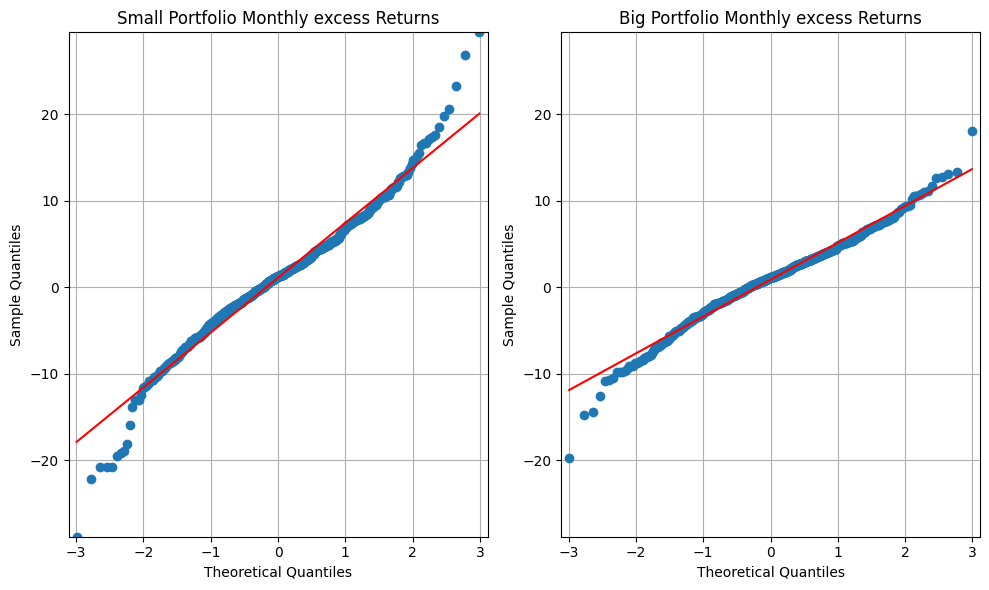

In [ ]:
#@title QQ-plot (정규분포 검사)

big = pfo_size['b_10']
small = pfo_size['s_10']

import statsmodels.api as sm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# Calculate the minimum and maximum y-values across both datasets
min_y = min(small.min(), big.min())
max_y = max(small.max(), big.max())

# QQ plot for 's_low' on the first subplot (ax1)
sm.qqplot(small, line='s', ax=ax1)
ax1.set_title('Small Portfolio Monthly excess Returns')
ax1.grid(True)

# QQ plot for 'b_low' on the second subplot (ax2)
sm.qqplot(big, line='s', ax=ax2)
ax2.set_title('Big Portfolio Monthly excess Returns')
ax2.grid(True)

# Set the y-axis limits for both subplots (ax1 and ax2)
ax1.set_ylim([min_y, max_y])
ax2.set_ylim([min_y, max_y])
# Set x-axis limits of ax2 to be the same as ax1
xlim = ax1.get_xlim()
ax2.set_xlim(xlim)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

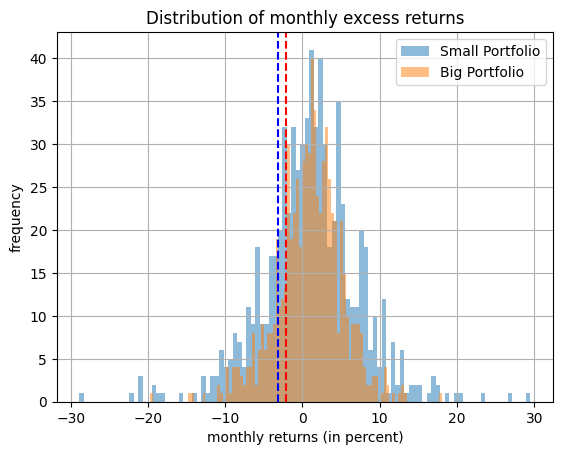

The dashed lines indicates 0.2 percentile. Red for Big, Blue for small


In [ ]:
#@title Histogram

q = 0.2
pfo_size['s_10'].hist(bins=100, alpha=0.5, label='Small Portfolio')
pfo_size['b_10'].hist(bins=100, alpha=0.5, label='Big Portfolio')
plt.axvline(pfo_size['s_10'].quantile(q), color='blue', linestyle='--')
plt.axvline(pfo_size['b_10'].quantile(q), color='red', linestyle='--')
plt.legend()
plt.xlabel('monthly returns (in percent)')
plt.ylabel('frequency')
plt.title('Distribution of monthly excess returns')
plt.show()
print('The dashed lines indicates ' + str(q) + ' percentile.' + ' Red for Big, Blue for small')

Paired t-test results:
t-statistic: 1.2184891640627125
p-value: 0.22343779498179997


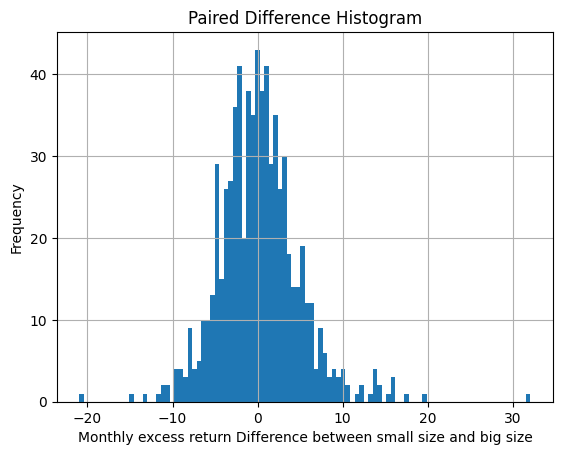

In [ ]:
#@title Dependent t-test

small = pfo_size['s_10']
big = pfo_size['b_10']

t_statistic, p_value = stats.ttest_rel(small, big)
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# If the p-value is greater than your significance level (0.05),
# you would fail to reject the null hypothesis (i.e. not enough evidence to suggest a significant difference)

paired_diff = (small - big)
paired_diff.hist(bins=100)
plt.title('Paired Difference Histogram')
plt.xlabel('Monthly excess return Difference between small size and big size')
plt.ylabel('Frequency')
plt.show()

# Annualized

In [ ]:
# moving average
# pfo_size_rolling = pfo_size.rolling(window=12).mean()

#@title without any overlap between the fiscal years
# Resample to annual frequency and calculate annual standard deviation
# groups the monthly data into yearly buckets.
# annual_std = pfo_size.resample('Y').std() * np.sqrt(12)

# Create a fiscal year column
pfo_size['fiscal_year'] = pfo_size.index.year
pfo_size.loc[pfo_size.index.month >= 7, 'fiscal_year'] = pfo_size.loc[pfo_size.index.month >= 7, 'fiscal_year'] + 1

# Group by fiscal year and calculate annual
annual_mean = pfo_size.groupby('fiscal_year').mean()*12
annual_std = pfo_size.groupby('fiscal_year').std() * np.sqrt(12)
# annual_std.dropna(inplace=True)

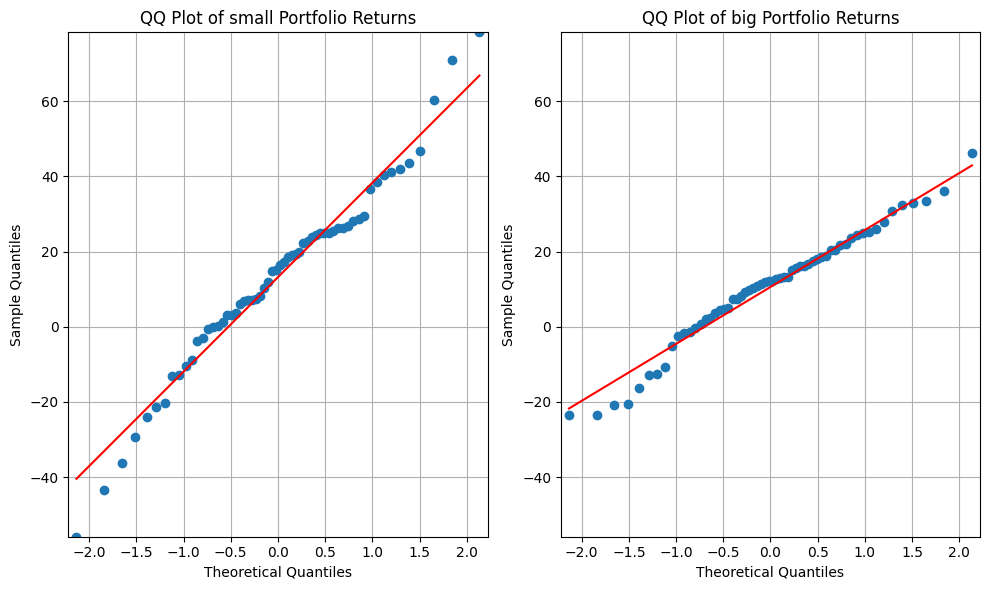

In [ ]:
#@title QQ-plot (annualized)

big = annual_mean['b_10']
small = annual_mean['s_10']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# Calculate the minimum and maximum y-values across both datasets
min_y = min(small.min(), big.min())
max_y = max(small.max(), big.max())

# QQ plot for 's_low' on the first subplot (ax1)
sm.qqplot(small, line='s', ax=ax1)
ax1.set_title('QQ Plot of small Portfolio Returns')
ax1.grid(True)

# QQ plot for 'b_low' on the second subplot (ax2)
sm.qqplot(big, line='s', ax=ax2)
ax2.set_title('QQ Plot of big Portfolio Returns')
ax2.grid(True)

# Set the y-axis limits for both subplots (ax1 and ax2)
ax1.set_ylim([min_y, max_y])
ax2.set_ylim([min_y, max_y])
# Set x-axis limits of ax2 to be the same as ax1
xlim = ax1.get_xlim()
ax2.set_xlim(xlim)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### QQ Plot Interpretation: Comparing Small vs. Big Size Portfolios

To evaluate the return distribution characteristics of small-cap and large-cap portfolios, we construct QQ plots of annualized returns for the `s_10` (smallest decile) and `b_10` (largest decile) portfolios. The plots juxtapose sample quantiles against theoretical quantiles from a standard normal distribution. Three notable features emerge:

1. **Slope of the Fitted Line (Volatility Indicator)**  
   The slope of the QQ line is significantly flatter for the `b_10` portfolio than for the `s_10`.  
   This reflects **lower empirical standard deviation** for large-cap returns, consistent with their lower volatility and more stable risk profiles. The slope in a QQ plot corresponds to the ratio of sample to theoretical standard deviation, reinforcing the volatility advantage of big stocks.

2. **Line–Scatter Fit (Distributional Regularity)**  
   The `b_10` plot shows a much tighter fit of the scatter points along the reference line, compared to the `s_10` portfolio.  
   This implies that large-cap returns conform more closely to the normal distribution. In contrast, the small-cap portfolio exhibits noticeable deviations, suggesting greater skewness, kurtosis, or latent regime switches. The result indicates that large-cap stocks exhibit **greater distributional regularity**, aligning with their more predictable behavior in large institutional portfolios.

3. **Tail Behavior (Asymmetry in Small-Cap Returns)**  
   For `s_10`, the right tail (positive returns) lies **above** the line, while the left tail (negative returns) lies **below**.  
   This pattern suggests **positive skewness**—i.e., occasional high positive returns but more frequent or severe downside shocks. Such asymmetry is common in small-cap stocks, which may have explosive upside potential but are also subject to default or delisting risk. The departure from symmetry in `s_10` strengthens the case for mixture modeling and asymmetric tail analysis in the TBTF framework.


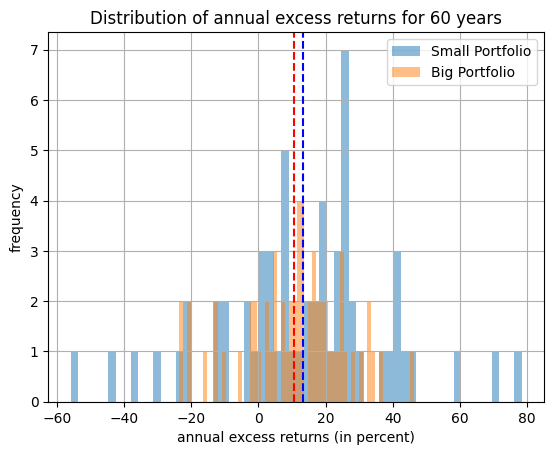

The dashed lines indicates the mean. Red for Big, Blue for small


In [ ]:
#@title Histogram
annual_mean['s_10'].hist(bins=len(annual_std), alpha=0.5, label='Small Portfolio')
annual_mean['b_10'].hist(bins=len(annual_std), alpha=0.5, label='Big Portfolio')
plt.axvline(annual_mean['s_10'].mean(), color='blue', linestyle='--')
plt.axvline(annual_mean['b_10'].mean(), color='red', linestyle='--')
plt.legend()
plt.xlabel('annual excess returns (in percent)')
plt.ylabel('frequency')
plt.title('Distribution of annual excess returns for ' + str(len(annual_std)) + ' years')
plt.show()
print('The dashed lines indicates each mean.' + ' Red for Big, Blue for small')

Paired t-test results:
t-statistic: 0.984
p-value: 0.329


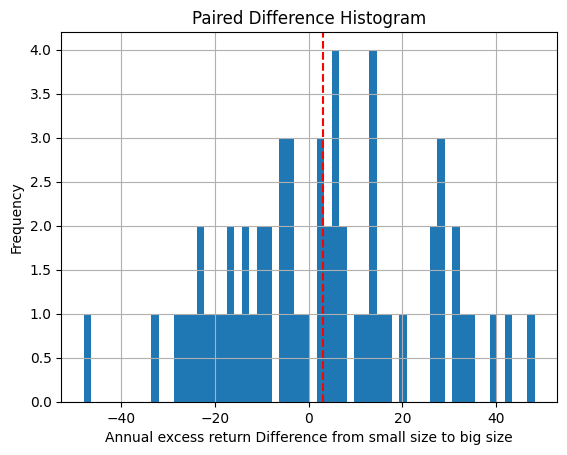

The dashed line indicates the median of the difference


In [ ]:
#@title Dependent t-test (annualized mean. Small sample)

small = annual_mean['s_10']
big = annual_mean['b_10']

t_statistic, p_value = stats.ttest_rel(small, big)
print("Paired t-test results:")
print("t-statistic:", round(t_statistic,3))
print("p-value:", round(p_value,3))

# If the p-value is greater than your significance level (0.05),
# you would fail to reject the null hypothesis (i.e. not enough evidence to suggest a significant difference)

paired_diff = (small - big)
paired_diff.hist(bins= len(annual_std) )
plt.axvline(paired_diff.median(), color='red', linestyle='--')
plt.title('Paired Mean Difference Histogram')
plt.xlabel('Annual excess return Difference from small size to big size')
plt.ylabel('Frequency')
plt.show()
print('The dashed line indicates the median of the difference')

Paired t-test results:
t-statistic: 7.535
p-value: 0.0


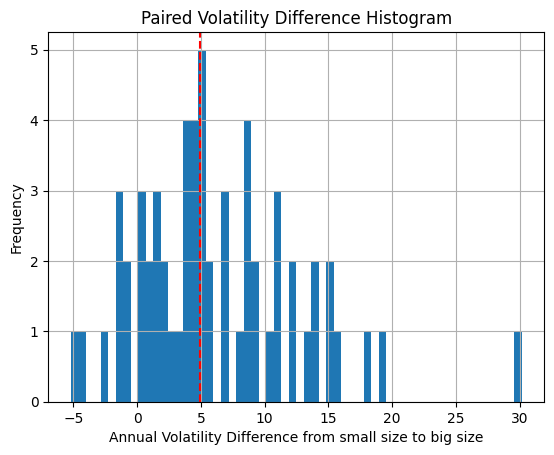

The dashed line indicates the median of the difference


In [ ]:
#@title Dependent t-test (annualized std. Small sample)

small = annual_std['s_10']
big = annual_std['b_10']

t_statistic, p_value = stats.ttest_rel(small, big)
print("Paired t-test results:")
print("t-statistic:", round(t_statistic,3))
print("p-value:", round(p_value,3))

# If the p-value is greater than your significance level (0.05),
# you would fail to reject the null hypothesis (i.e. not enough evidence to suggest a significant difference)

paired_diff = (small - big)
paired_diff.hist(bins= len(annual_std) )
plt.axvline(paired_diff.median(), color='red', linestyle='--')
plt.title('Paired Volatility Difference Histogram')
plt.xlabel('Annual Volatility Difference from small size to big size')
plt.ylabel('Frequency')
plt.show()
print('The dashed line indicates the median of the difference')

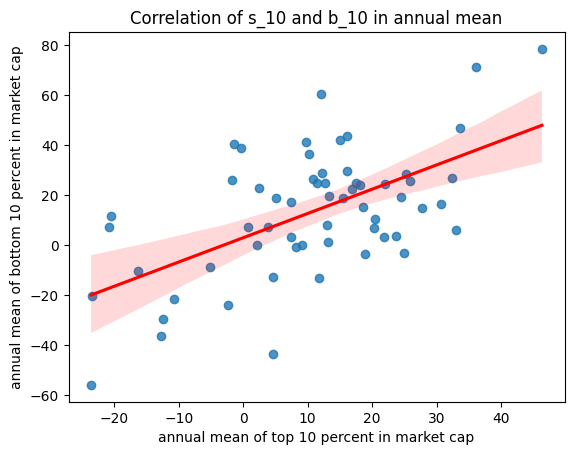

The correlation coefficient is 1.0




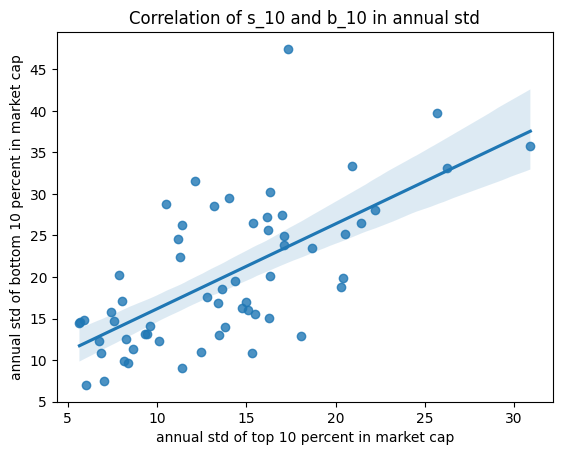

The correlation coefficient is 1.0


In [ ]:
#@title Correlation of s_10 and b_10 in annual mean or std
sns.regplot(data = annual_mean, x='b_10', y='s_10', order=1, line_kws={'color': 'red'})
plt.xlabel('annual mean of top 10 percent in market cap')
plt.ylabel('annual mean of bottom 10 percent in market cap')
plt.title('Correlation of s_10 and b_10 in annual mean')
plt.show()
print('The correlation coefficient is ' + str(annual_mean['s_10'].corr(annual_mean['b_10']).round(0)) )
print('\n')

sns.regplot(data = annual_std, x='b_10', y='s_10', order=1)
plt.xlabel('annual std of top 10 percent in market cap')
plt.ylabel('annual std of bottom 10 percent in market cap')
plt.title('Correlation of s_10 and b_10 in annual std')
plt.show()
print('The correlation coefficient is ' + str(annual_std['s_10'].corr(annual_std['b_10']).round(0)) )

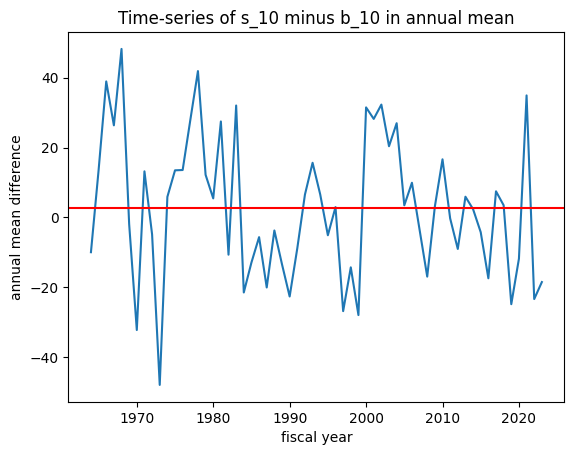

The unconditional mean of the difference is 3.0 percent, annually




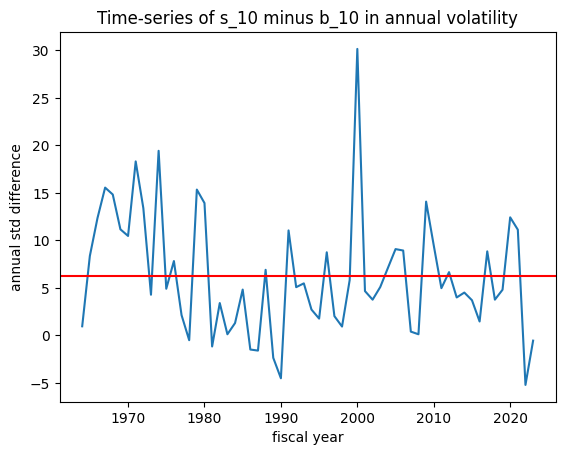

The unconditional mean of the difference is 6.0 percent, annually




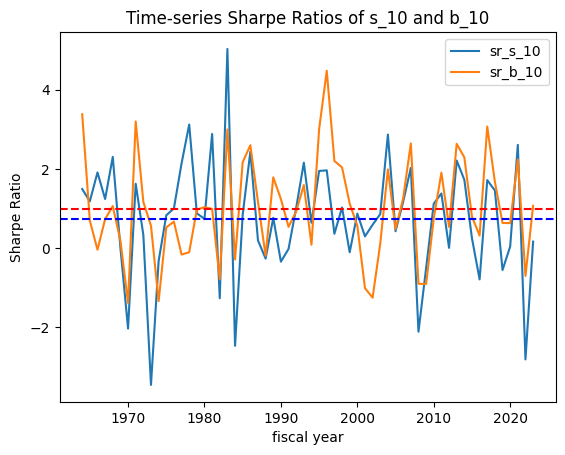

The unconditional mean Annual Sharpe ratio of s_10 is 0.74
The unconditional mean annual Sharpe ratio of b_10 is 0.99


In [ ]:
#@title Time-series of s_10 vs. b_10
temp = annual_mean['s_10'] - annual_mean['b_10']
temp.plot()
plt.axhline(y= temp.mean(), color='r', linestyle='-')
plt.xlabel('fiscal year')
plt.ylabel('annual mean difference')
plt.title('Time-series of s_10 minus b_10 in annual mean')
plt.show()
print('The unconditional mean of the difference is '+str(temp.mean().round(0))+ ' percent, annually')
print('\n')

temp = annual_std['s_10'] - annual_std['b_10']
temp.plot()
plt.axhline(y= temp.mean(), color='r', linestyle='-')
plt.xlabel('fiscal year')
plt.ylabel('annual std difference')
plt.title('Time-series of s_10 minus b_10 in annual volatility')
plt.show()
print('The unconditional mean of the difference is '+str(temp.mean().round(0))+ ' percent, annually')
print('\n')

# annual_mean and annual_std have the same index
df = pd.DataFrame(index=annual_mean.index)
df['sr_s_10'] = annual_mean['s_10'] / annual_std['s_10']
df['sr_b_10'] = annual_mean['b_10'] / annual_std['b_10']

df['sr_s_10'].plot()
df['sr_b_10'].plot()
plt.axhline(y= df['sr_s_10'].mean(), color='b', linestyle='dashed')
plt.axhline(y= df['sr_b_10'].mean(), color='r', linestyle='dashed')
plt.legend()
plt.xlabel('fiscal year')
plt.ylabel('Sharpe Ratio')
plt.title('Time-series Sharpe Ratios of s_10 and b_10')
plt.show()
print('The unconditional mean Annual Sharpe ratio of s_10 is '+str(df['sr_s_10'].mean().round(2)))
print('The unconditional mean annual Sharpe ratio of b_10 is '+str(df['sr_b_10'].mean().round(2)))

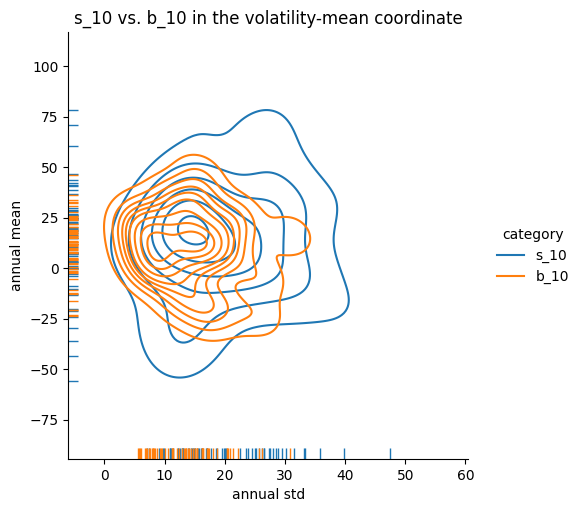

In [ ]:
#@title s_10 vs. b_10 in the volatility-mean coordinate

# Create a list of category names
categories = ['s_10', 'b_10']

# Initialize an empty list to store dataframes
dfs = []

# Iterate through categories and create melted dataframes
for category in categories:
    # Create a temporary dataframe with selected columns and category label
    temp_mean = annual_mean[[category]].copy()  # Keep the index
    temp_mean['category'] = category
    temp_mean.rename(columns={category: 'annual_mean'}, inplace=True)

    temp_std = annual_std[[category]].copy()  # Keep the index
    temp_std['category'] = category
    temp_std.rename(columns={category: 'annual_std'}, inplace=True)

    # Merge the temporary dataframes for mean and std, keeping the index
    temp_df = pd.merge(temp_mean, temp_std, on=['fiscal_year', 'category'])

    # Append the temporary dataframe to the list
    dfs.append(temp_df)

# Concatenate all the dataframes in the list into a single dataframe, keeping the index
df = pd.concat(dfs, ignore_index=False)

# Now create the displot
sns.displot(
    data = df,  # Use the reshaped DataFrame
    x="annual_std",
    y="annual_mean",
    hue="category",  # Use the extracted category for hue
    kind="kde",
    rug=True,
)
plt.xlabel('annual std')
plt.ylabel('annual mean')
plt.title('s_10 vs. b_10 in the volatility-mean coordinate')
plt.show()
